This notebook explains how to define a classification task for vision with Lasagne and theano.

To execute a cell: Ctrl-Enter.

The code was executed with the default configuration of Theano: `floatX=float64`, `device=cpu` and the configuration for GPU `floatX=float32,device=cuda`.

In [1]:
import os
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,mode=FAST_RUN'
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cuda,mode=FAST_RUN'
import numpy as np
import theano
import theano.tensor as T
import lasagne
seed = 1
lasagne.random.set_rng(np.random.RandomState(seed))

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX TITAN Black (0000:02:00.0)


# Hyperparameters

The following are hyperparameters that will have an impact on the learning algorithm.

In [2]:
# Architecture
MODEL_TYPE = 'mlp'
N_HIDDEN = 50
DEPTH = 2
NON_LINEARITY = lasagne.nonlinearities.rectify

# Convolutional hyperparameters
CONV_DEPTH = 2
NUM_FILTERS = 32
FILTER_SIZE = (5,5)
POOL_SIZE = (2,2)

# Dropout parameters
#DROP_INPUT = 0.2
#DROP_HIDDEN = 0.8
DROP_INPUT = None
DROP_HIDDEN = None

# Number of epochs to train the net
NUM_EPOCHS = 50

# Optimization learning rate
LEARNING_RATE = 0.01

# Batch Size
BATCH_SIZE = 128

Define the optimizer to be used for the training. An optimizer can be seen as a function that takes a gradient, obtained by backpropagation, and returns an update to by applied to the current parameters. Other optimizers can be found in: [optimizer reference](http://lasagne.readthedocs.io/en/latest/modules/updates.html?highlight=update). In order to be able to change the learning rate dynamically, we must use a shared variable that will be accessible afterwards.

In [3]:
eta = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
my_optimizer = lambda loss, params: lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=eta, momentum=0.9)

# Dataset
In this example, we are using the celebrated [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The following are functions that download the MNIST dataset, resize it into a convenient numpy array for images of size `(n_example, n_channel, img_width, img_height)` and split the dataset into a train set (50k images) and a validation set (10k images). The pixels are normalized by 255.

In [4]:
import os
def load_mnist():
    """
    A dataloader for MNIST

    """
    
    from urllib.request import urlretrieve
  
    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        return data / np.float32(255)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
# Load the dataset
print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
input_shape = X_train[0].shape
print(y_train.shape)
input_shape = (None, input_shape[0], input_shape[1], input_shape[2])

Loading data...
(50000,)


(50000, 1, 28, 28)


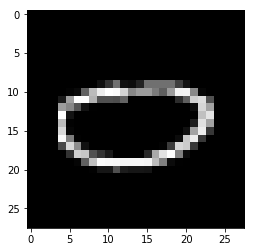

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
print(X_train.shape)
plt.imshow(X_train[np.random.randint(0,y_train.shape[0])][0], cmap='gray')

The following auxiliary function creates a minibatch in a 3D tensor (batch_size,img_height,img_width).

In [7]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """
    Return a minibatch of images with the associated targets

    Keyword arguments:
    :type inputs: numpy.ndarray
    :param inputs: the dataset of images
    :type targets: numpy.ndarray
    :param targets: the targets associated to the dataset
    :type batchsize: int
    :param batchsize: the number of datapoints in the minibatch
    :type shuffle: bool
    :param shuffle: a flag if we want to shuffle the dataset
    """
    
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Model definition

The next two functions are general functions for creating multi-layer perceptron (mlp) and convolutional neural networks (cnn).

In [8]:
def create_mlp(
    input_shape,
    input_var=None,
    nonlinearity = lasagne.nonlinearities.rectify,
    depth=2, 
    n_hidden=800, 
    drop_input=.2,
    drop_hidden=.5):
    """
    A generic function for creating a multi-layer perceptron.
    If n_hidden is given as a list, then depth is ignored.
    
    :type input_shape: tuple
    :param input_shape: a tuple containing the shape of the input
    :type input_var: theano.tensor.var.TensorVariable
    :param input_var: a theano symbolic variable, created automatically if None
    :type nonlinearity: lasagne.nonlinearities
    :param nonlinearity: a nonlinearity function that follows all dense layers
    :type depth: int
    :param depth: the depth of the mlp part; number of dense layers
    :type n_hidden: int or list
    :param n_hidden: number of hidden units per layer (if int, the same for all layers)
    :type drop_input: float
    :param drop_input: the probability of dropout for the input
    :type drop_hidden: float
    :param drop_hidden: the probability of dropout for the hidden units
    """

    # if input_shape is None, then the mlp is used on top of an existing model
    if input_shape:
        
        # if input_var is None, lasagne create 
        # automatically the associated theano variable
        network = lasagne.layers.InputLayer(
            shape=input_shape,
            input_var=input_var
        )
    else:
        network = input_var
    
    if drop_input:
        network = lasagne.layers.dropout(
            incoming=network,
            p=drop_input
        )
    
    if not isinstance(n_hidden, list):
        n_hidden = [n_hidden] * depth
    depth = len(n_hidden)
    
    for i in range(depth):
        network = lasagne.layers.DenseLayer(
            incoming=network, 
            num_units=n_hidden[i],
            nonlinearity=nonlinearity
        )
        if drop_hidden:
            network = lasagne.layers.dropout(
                incoming=network, 
                p=drop_hidden
            )

    network = lasagne.layers.DenseLayer(
        incoming=network, 
        num_units=10, 
        nonlinearity=lasagne.nonlinearities.softmax
    )
    return network

In [9]:
# Note: In lasagne, the batchnorm must be applied to an incoming layer
# (BN - 32x5x5 conv - MaxPool) - (BN - 32x5x5 conv - MaxPool) - (BN - FC w/dropout) - (BN - FC w/dropout) - Output
def create_cnn(
    input_shape,
    input_var=None,
    conv_nonlinearity=lasagne.nonlinearities.rectify,
    conv_depth=2, 
    num_filters=32,
    filter_size=(5,5),
    pool_size=(2,2),
    mlp_nonlinearity=lasagne.nonlinearities.rectify,
    mlp_depth=2, 
    mlp_n_hidden=800, 
    mlp_drop_input=.2,
    mlp_drop_hidden=.5):
    
    """
    A generic function for creating convolutional neural network.
    
    :type input_shape: tuple
    :param input_shape: a tuple containing the shape of the input
    :type input_var: theano.tensor.var.TensorVariable
    :param input_var: a theano symbolic variable
    :type conv_nonlinearity: lasagne.nonlinearities
    :param conv_nonlinearity: a nonlinearity function that follows all convolutions
    :type conv_depth: int
    :param conv_depth: the depth of the convolutional part; number of conv-maxpool
    :type num_filters: int or list
    :param num_filters: number of filters per convolutional layer (if int, the same for all layers)
    :type filter_size: pair(tuple) or a list of pairs(tuple)
    :param filter_size: the shape of the filters (the number of channels is automatically fixed)
    :type pool_size: pair(tuple) or a list of pairs(tuple)
    :param pool_size: the shape of the pooling (the number of channels is automatically fixed)
    :type mlp_nonlinearity: lasagne.nonlinearities
    :param mlp_nonlinearity: a nonlinearity function that follows all dense layers
    :type mlp_depth: int
    :param mlp_depth: the depth of the mlp part; number of dense layers
    :type mlp_n_hidden: int or list
    :param mlp_n_hidden: number of hidden units per layer (if int, the same for all layers)
    :type mlp_drop_input: float
    :param mlp_drop_input: the probability of dropout for the input
    :type mlp_drop_hidden: float
    :param mlp_drop_hidden: the probability of dropout for the hidden units

   """
    
    if not isinstance(num_filters, list):
        num_filters = [num_filters] * conv_depth
    assert(len(num_filters)==conv_depth)
    
    if not isinstance(filter_size, list):
        filter_size = [filter_size] * conv_depth
    assert(len(filter_size)==conv_depth)
        
    if not isinstance(pool_size, list):
        pool_size = [pool_size] * conv_depth
    assert(len(pool_size)==conv_depth)
    
    network = lasagne.layers.InputLayer(
        shape=input_shape, 
        input_var=input_var
    )

    for i in range(conv_depth):
        network = lasagne.layers.Conv2DLayer(
                network, num_filters=num_filters[i], filter_size=filter_size[i],
                nonlinearity=conv_nonlinearity,
                W=lasagne.init.GlorotUniform())
        network = lasagne.layers.batch_norm(network)
        network = lasagne.layers.MaxPool2DLayer(network, pool_size=pool_size[i])
    
    network = create_mlp(None, network, mlp_nonlinearity, mlp_depth, mlp_n_hidden, mlp_drop_input, mlp_drop_hidden)
    
    return network

In [10]:
# Create a network
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

if MODEL_TYPE == 'mlp':
    network = create_mlp(
        input_shape,
        input_var=input_var,
        nonlinearity=NON_LINEARITY,
        depth=DEPTH, 
        n_hidden=N_HIDDEN, 
        drop_input=DROP_INPUT, 
        drop_hidden=DROP_HIDDEN)
else:
    network = create_cnn(
        input_shape,
        input_var = input_var,
        conv_nonlinearity = lasagne.nonlinearities.rectify,
        conv_depth = CONV_DEPTH, 
        num_filters = NUM_FILTERS,
        filter_size = FILTER_SIZE,
        pool_size = POOL_SIZE,
        mlp_nonlinearity=NON_LINEARITY,
        mlp_depth=DEPTH, 
        mlp_n_hidden=N_HIDDEN, 
        mlp_drop_input=DROP_INPUT,
        mlp_drop_hidden=DROP_HIDDEN)  

# Optimization

In the following, we want to maximize the probability to output the right digit given the image. To do this, we retrieve the output of our model, which is a softmax (probability distribution) over the 10 digits, and we compare it to the actual target. Finally, since we are using minibatches of size `BATCH_SIZE`, we compute the mean over the examples of the minibatch.

In [11]:
# Create a loss expression for training
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()

In [12]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = my_optimizer(loss, params)

In [13]:
# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
valid_prediction = lasagne.layers.get_output(network, deterministic=True)
valid_loss = lasagne.objectives.categorical_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()

# We also create an expression for the classification accuracy:
valid_acc = T.mean(T.eq(T.argmax(valid_prediction, axis=1), target_var), dtype=theano.config.floatX)

# Compile a second function computing the validation loss and accuracy:
valid_fn = theano.function([input_var, target_var], [valid_loss, valid_acc])

# Training loop

The following training loop is minimal and often insufficient for real-world purposes.
The idea here is to show the minimal requirements for training a neural network.
Also, we plot to show the evolution of the train and validation losses.|

<IPython.core.display.Javascript object>


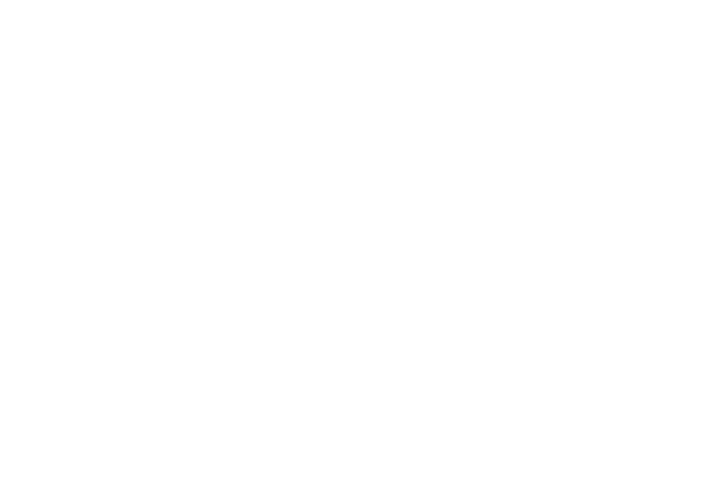

<IPython.core.display.Javascript object>


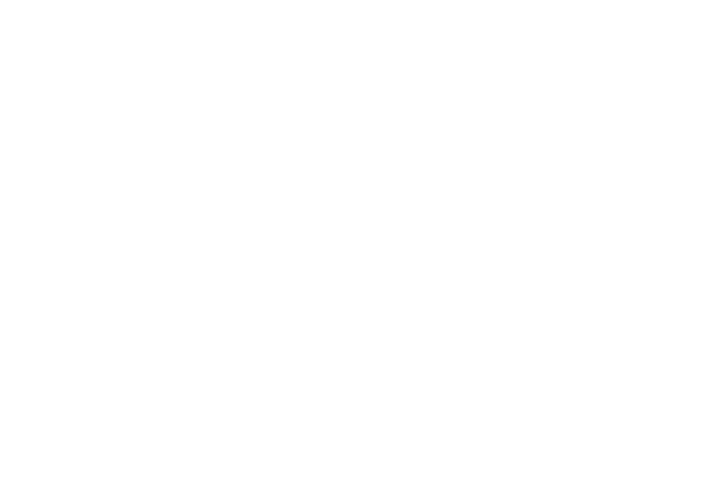

In [14]:
%matplotlib notebook

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['figure.dpi'] = 80

import time
def train(
    train_fn,
    X_train,
    y_train,
    valid_fn,
    X_valid,
    y_valid,
    num_epochs=100,
    batchsize=64):
    
    ###################
    # code for plotting
    ###################
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('NLL')
    ax.set_xlim(0,50)
    ax.set_ylim(0,0.2)
    
    train_log = []
    valid_log = []
    ###################
    
    n_train_batches = X_train.shape[0] // batchsize # Warning last examples are not used
    n_valid_batches = X_valid.shape[0] // batchsize
    
    for epoch in range(50):
        
        train_loss = 0
        for inputs, targets in iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
            train_loss += train_fn(inputs, targets)

        valid_loss = 0
        for inputs, targets in iterate_minibatches(X_valid, y_valid, batchsize, shuffle=False):
            loss,_ = valid_fn(inputs, targets)
            valid_loss += loss
        
        ###################
        # code for plotting
        ###################
        train_log.append(train_loss/n_train_batches)
        valid_log.append(valid_loss/n_valid_batches)
        #print(train_loss/n_train_batches, valid_loss/n_valid_batches)
        if ax.lines:
            ax.lines[0].set_xdata(range(0,epoch+1))
            ax.lines[0].set_ydata(train_log)
            ax.lines[1].set_xdata(range(0,epoch+1))
            ax.lines[1].set_ydata(valid_log)
        else:
            ax.plot(epoch, train_log[epoch], 'b', label='train')
            ax.plot(epoch, valid_log[epoch], 'r', label='valid')
            ax.legend()
            ax.grid()
        fig.canvas.draw()
        time.sleep(0.1)
        ###################

train(train_fn, X_train, y_train, valid_fn, X_val, y_val)

The following training loop contains features that are interesting to consider:
- early-stopping
- logging and filenames
- checkpointing
- adaptive step-size (optional)

The first three are the most important ones.


In [14]:
import time
import pickle
def train(
    train_fn,
    X_train,
    y_train,
    valid_fn,
    X_valid,
    y_valid,
    num_epochs=100,
    batchsize=64):
    
    print("Starting training...")
    train_loss_array = []
    valid_loss_array = []
    
    # early-stopping parameters
    n_iter = 0
    n_train_batches = X_train.shape[0] // batchsize # Warning last examples are not used
    n_valid_batches = X_valid.shape[0] // batchsize
    patience = 10 * n_train_batches # look as this many examples regardless
    patience_increase = 2.  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_valid_loss = np.inf
    best_iter = 0
    test_score = 0.

    epoch = 0
    done_looping = False
    
    if not isinstance(N_HIDDEN, list):
        n_hidden = [N_HIDDEN] * DEPTH
    
    exp_log_filename = '{}_lr-{}_arch-{}_bs-{}_seed-{}.log'.format(
        MODEL_TYPE, 
        LEARNING_RATE, 
        '-'.join(str(i) for i in n_hidden),
        batchsize,
        seed
    )
    with open(exp_log_filename, 'w') as f:
        log_line = '{} \t\t{} \t\t{} \t\t{} \n'.format('epoch', 'train_loss', 'valid_loss', 'valid_acc')
        f.write(log_line)
    
    while epoch < num_epochs and not done_looping:
        
        train_loss = 0
        start_time = time.time()
        for inputs, targets in iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
            train_loss += train_fn(inputs, targets)

        # And a full pass over the validation data:
        valid_loss = 0
        valid_acc = 0
        for inputs, targets in iterate_minibatches(X_valid, y_valid, batchsize, shuffle=False):
            loss, acc = valid_fn(inputs, targets)
            valid_loss += loss
            valid_acc += acc

        # Then we print the results for this epoch:
        avg_train_loss = train_loss / n_train_batches
        avg_valid_loss = valid_loss / n_valid_batches
        avg_valid_acc = valid_acc / n_valid_batches * 100
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(avg_train_loss))
        print("  validation loss:\t\t{:.6f}".format(avg_valid_loss))
        print("  validation accuracy:\t\t{:.2f} %".format(avg_valid_acc))
        train_loss_array.append(avg_train_loss)
        valid_loss_array.append(avg_valid_loss)
        
        with open(exp_log_filename, 'a') as f:
            log_line = '{} \t\t{:.6f} \t\t{:.6f} \t\t{:.2f} \n'.format(epoch, avg_train_loss, avg_valid_loss, avg_valid_acc)
            f.write(log_line)
        
        # if we got the best validation score until now
        n_iter += n_train_batches
        if valid_loss < best_valid_loss:

            #improve patience if loss improvement is good enough
            if valid_loss < best_valid_loss * improvement_threshold:
                patience = max(patience, n_iter * patience_increase)

                best_valid_loss = valid_loss
                best_iter = n_iter

                # save the best model
                with open('best_model.pkl', 'wb') as f:
                    all_params_values = lasagne.layers.get_all_param_values(network)
                    pickle.dump(all_params_values, f)
                eta.set_value(lasagne.utils.floatX(eta.get_value() * 1.2))
                    
            if patience <= n_iter:
                done_looping = True
                break
                
        else:
            eta.set_value(lasagne.utils.floatX(eta.get_value() * 0.5))
            
        epoch += 1

train_log, valid_log = train(train_fn, X_train, y_train, valid_fn, X_val, y_val)

Starting training...
Epoch 1 of 100 took 6.172s
  training loss:		0.148822
  validation loss:		0.066833
  validation accuracy:		98.11 %
Epoch 2 of 100 took 6.148s
  training loss:		0.052326
  validation loss:		0.062839
  validation accuracy:		98.30 %
Epoch 3 of 100 took 6.149s
  training loss:		0.041117
  validation loss:		0.046483
  validation accuracy:		98.59 %
Epoch 4 of 100 took 6.146s
  training loss:		0.035561
  validation loss:		0.038919
  validation accuracy:		98.85 %
Epoch 5 of 100 took 6.147s
  training loss:		0.030619
  validation loss:		0.048502
  validation accuracy:		98.58 %
Epoch 6 of 100 took 6.148s
  training loss:		0.013314
  validation loss:		0.034559
  validation accuracy:		99.14 %
Epoch 7 of 100 took 6.143s
  training loss:		0.010780
  validation loss:		0.032638
  validation accuracy:		99.19 %
Epoch 8 of 100 took 6.146s
  training loss:		0.009872
  validation loss:		0.034724
  validation accuracy:		99.17 %


KeyboardInterrupt: 

In [15]:
!tail mlp_lr-0.01_arch-50-50_bs-64_seed-1.log

7 		0.052241 		0.093937 		97.31 
8 		0.035416 		0.088671 		97.49 
9 		0.032947 		0.092601 		97.36 
10 		0.025395 		0.087569 		97.51 
11 		0.024273 		0.090241 		97.49 
12 		0.020486 		0.087958 		97.54 
13 		0.018486 		0.087436 		97.60 
14 		0.018071 		0.087579 		97.57 
15 		0.017384 		0.087928 		97.55 
16 		0.016954 		0.087948 		97.55 


In [16]:
# load the saved model
all_params_values = pickle.load(open('best_model.pkl','rb'))
lasagne.layers.set_all_param_values(network, all_params_values)

# After training, we compute the test error.
test_loss, test_acc = valid_fn(X_test, y_test)
print("Final results:")
print("  test loss:\t\t\t {:.6f}".format(np.asscalar(test_loss)))
print("  test accuracy:\t\t {:.2f} %".format(np.asscalar(test_acc*100)))

NameError: name 'pickle' is not defined